### 1) Case Data

- Case: Data on COVID-19 infection cases in South Korea

### 2) Patient Data

- PatientInfo: Epidemiological data on COVID-19 patients in South Korea

### 3) Time Series Data

- Time: Time series data on COVID-19 status in South Korea
- TimeAge: Time series data on COVID-19 status by age group in South Korea
- TimeGender: Time series data on COVID-19 status by gender in South Korea
- TimeProvince: Time series data on COVID-19 status by province in South Korea

### 4) Additional Data

- Region: Location and statistical data for the regions in South Korea
- Weather: Weather data for the regions of South Korea
- SearchTrend: Trend data for keywords searched in Naver, one of the largest portals in South Korea
- SeoulFloating: Data on the floating population in Seoul, South Korea (from SK Telecom Big Data Hub)
- Policy: Data on government policy for COVID-19 in South Korea

In [5]:
import glob
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
project_directory = "/Applications/Projects/Covid19"

file_path_pattern = os.path.join(project_directory, "*.csv")

filenames = glob.glob(file_path_pattern)

dataframes = {}

for filename in filenames:
    short_filename = os.path.basename(filename)

    dataframe = pd.read_csv(filename)
    dataframes[short_filename] = dataframe

In [3]:
seoul = dataframes['seoul_floating.csv']
timeage = dataframes['time_age.csv']
searchtrend = dataframes['search_trend.csv']
time_province = dataframes['time_province.csv']
weather = dataframes['weather.csv']
patientinfo = dataframes['patient_info.csv']
region = dataframes['region.csv']
timegender = dataframes['time_gender.csv']
policy = dataframes['policy.csv']
case = dataframes['case.csv']
time = dataframes['time.csv']

### Before the Start..
- We make a structured dataset based on the report materials of KCDC and local governments.

- In Korea, we use the terms named '-do', '-si', '-gun' and '-gu',

- The meaning of them are explained below.

## Levels of administrative divisions in South Korea
### Upper Level (Provincial-level divisions)
- Special City:
Seoul

- Metropolitan City:
Busan / Daegu / Daejeon / Gwangju / Incheon / Ulsan

- Province(-do):
Gyeonggi-do / Gangwon-do / Chungcheongbuk-do / Chungcheongnam-do / Jeollabuk-do / Jeollanam-do / Gyeongsangbuk-do / Gyeongsangnam-do

### Lower Level (Municipal-level divisions)
- City(-si)

[List of cities in South Korea](https://en.wikipedia.org/wiki/List_of_cities_in_South_Korea)

- Country(-gun)

[List of counties of South Korea](https://en.wikipedia.org/wiki/List_of_counties_of_South_Korea)

- District(-gu)

[List of districts in South Korea](https://en.wikipedia.org/wiki/List_of_districts_in_South_Korea)

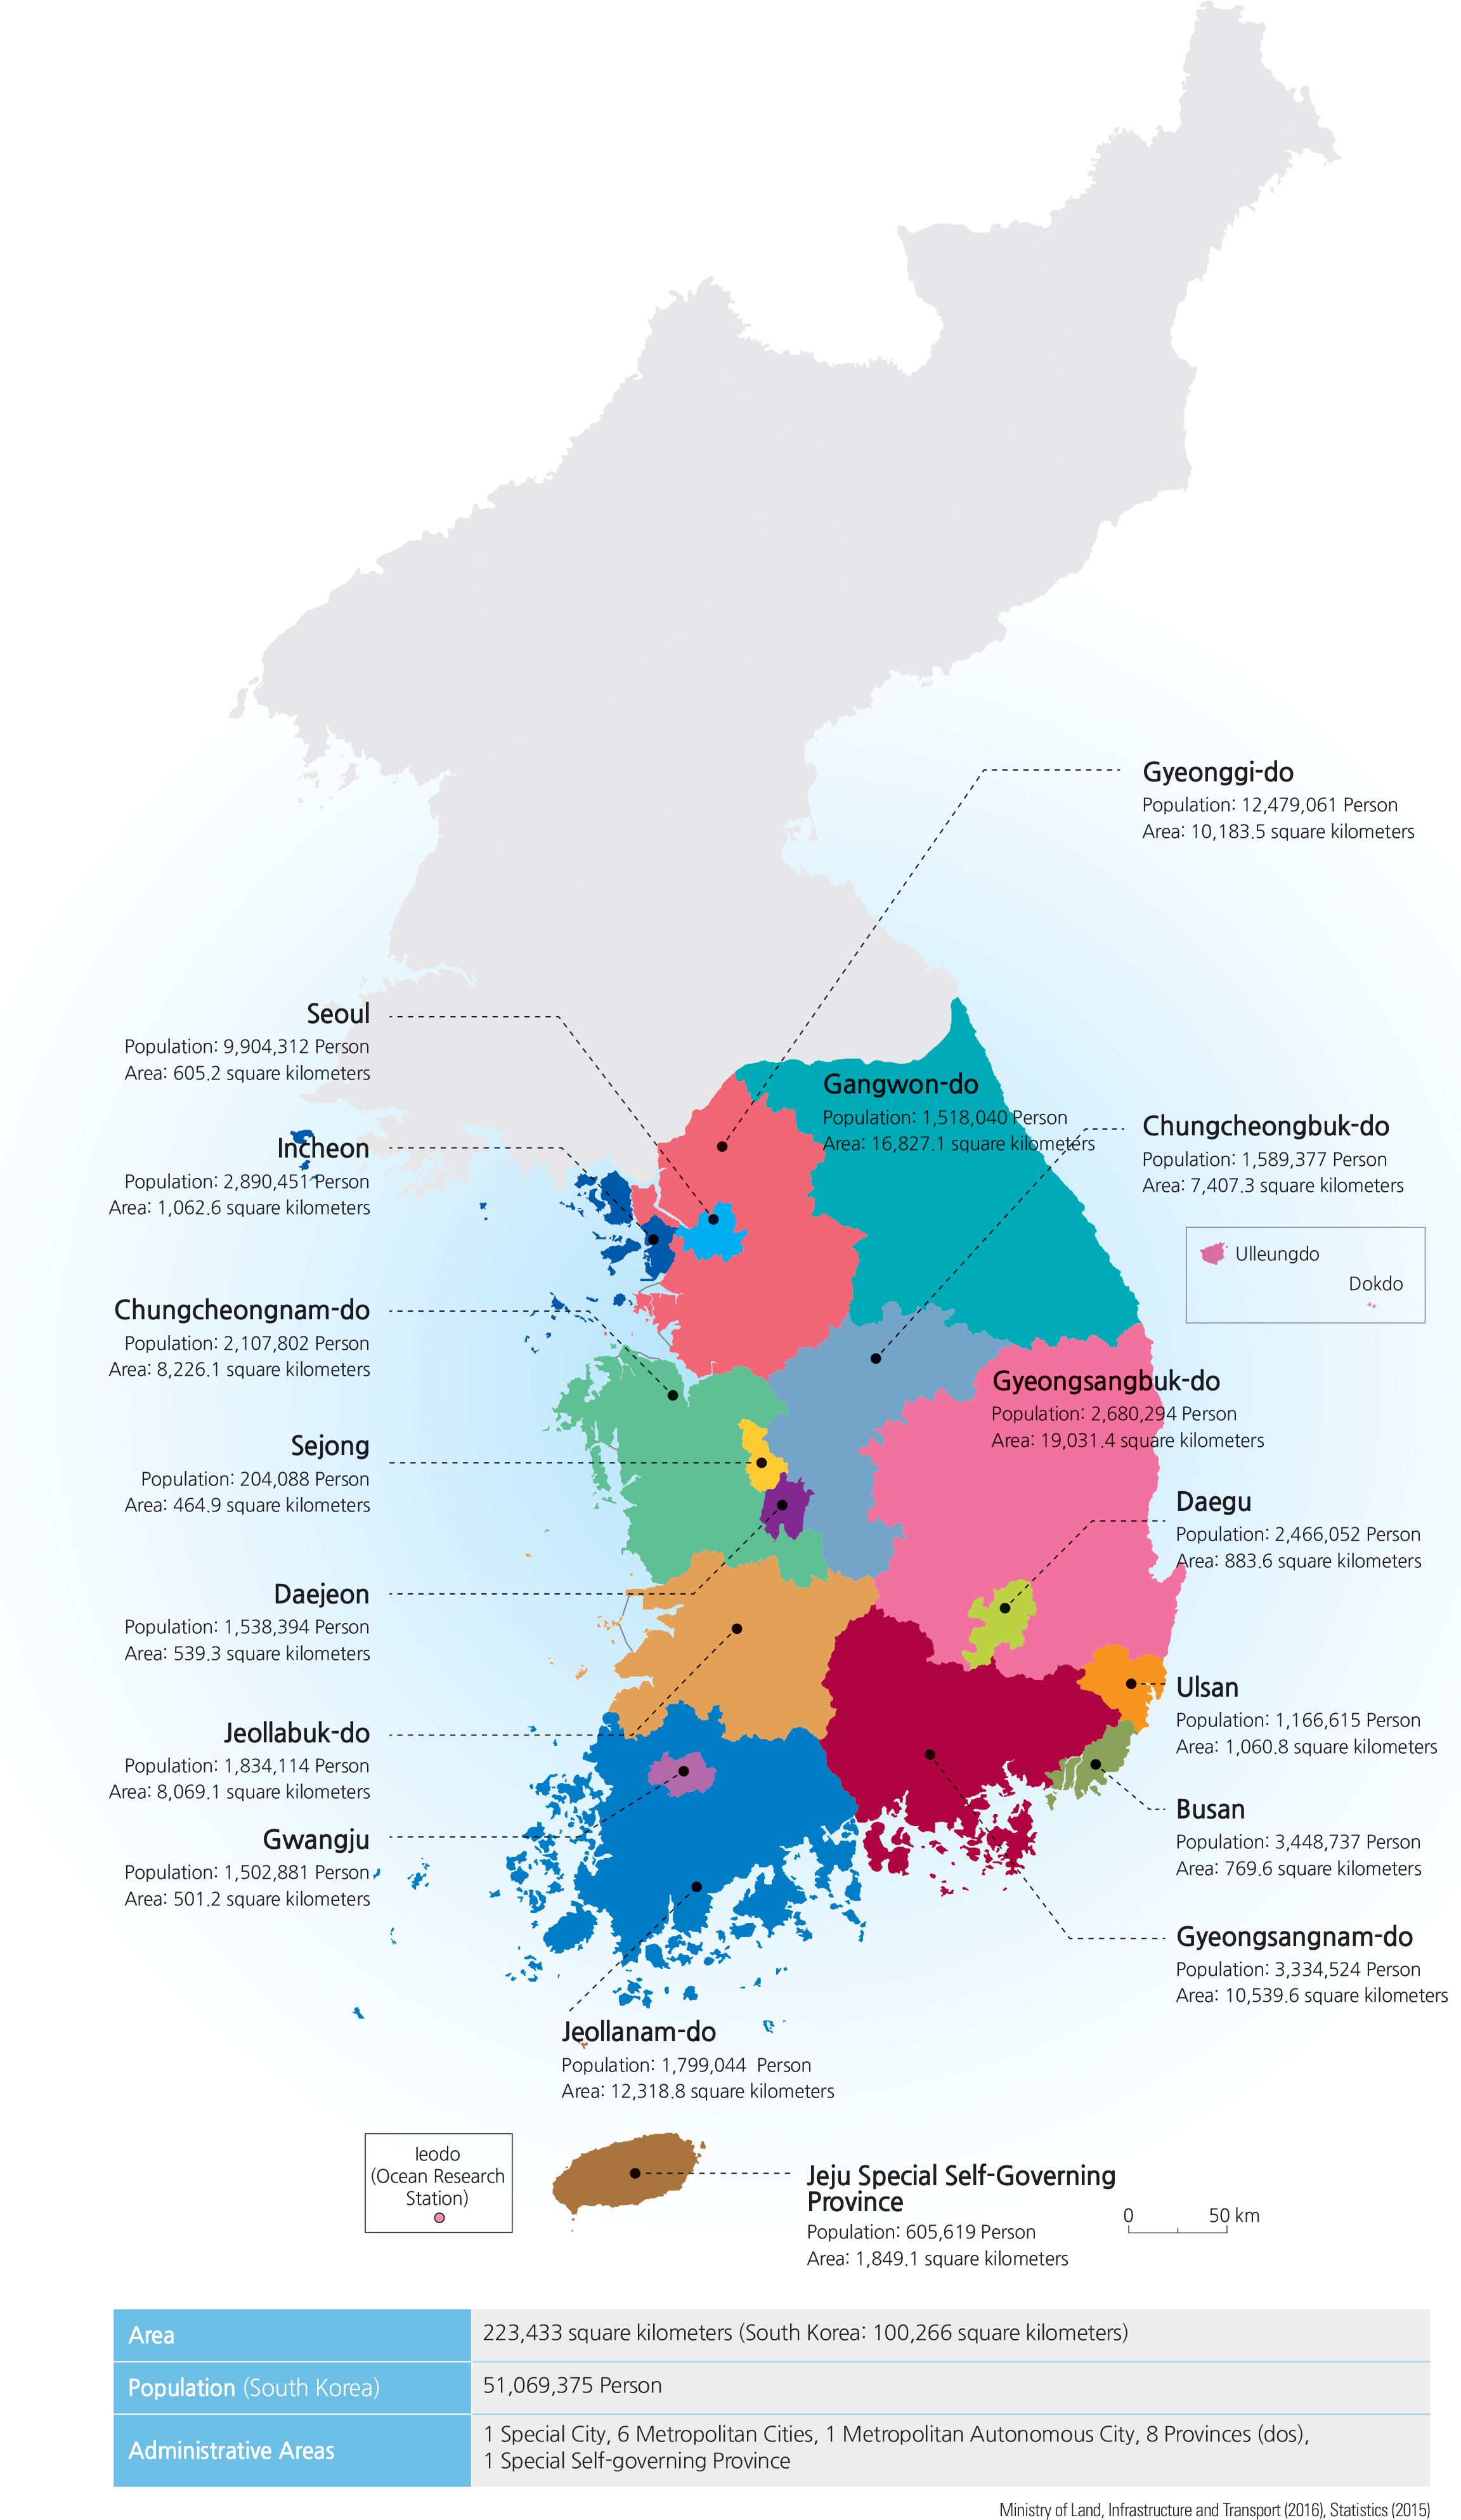

### Sources

- http://nationalatlas.ngii.go.kr/pages/page_1266.php
- https://en.wikipedia.org/wiki/Administrative_divisions_of_South_Korea


## 1) Case

### Data of COVID-19 infection cases in South Korea
1. case_id: the ID of the infection case

    -       case_id(7) = region_code(5) + case_number(2)
    -       You can check the region_code in 'Region.csv'
- province: Special City / Metropolitan City / Province(-do)
- city: City(-si) / Country (-gun) / District (-gu)

    -       The value 'from other city' means that where the group infection started is other city.
- group: TRUE: group infection / FALSE: not group
    -       If the value is 'TRUE' in this column, the value of 'infection_cases' means the name of group.
    -       The values named 'contact with patient', 'overseas inflow' and 'etc' are not group infection.
- infection_case: the infection case (the name of group or other cases)
     -      The value 'overseas inflow' means that the infection is from other country.
     -      The value 'etc' includes individual cases, cases where relevance classification is ongoing after investigation, and cases under investigation.
- confirmed: the accumulated number of the confirmed
- latitude: the latitude of the group (WGS84)
- longitude: the longitude of the group (WGS84)

In [4]:
case.head()

case_id province          city  group               infection_case  \
0   1000001    Seoul    Yongsan-gu   True                Itaewon Clubs   
1   1000002    Seoul     Gwanak-gu   True                      Richway   
2   1000003    Seoul       Guro-gu   True          Guro-gu Call Center   
3   1000004    Seoul  Yangcheon-gu   True  Yangcheon Table Tennis Club   
4   1000005    Seoul     Dobong-gu   True              Day Care Center   

   confirmed   latitude   longitude  
0        139  37.538621  126.992652  
1        119   37.48208  126.901384  
2         95  37.508163  126.884387  
3         43  37.546061  126.874209  
4         43  37.679422  127.044374

## 2) PatientInfo

### Epidemiological data of COVID-19 patients in South Korea
1. patient_id: the ID of the patient

    -   patient_id(10) = region_code(5) + patient_number(5)
    -   You can check the region_code in 'Region.csv'
    -   There are two types of the patient_number

            1) local_num: The number given by the local government.  
            2) global_num: The number given by the KCDC




- sex: the sex of the patient
- age: the age of the patient

            0s: 0 ~ 9
            10s: 10 ~ 19
            ...
            90s: 90 ~ 99
            100s: 100 ~ 109
      
- country: the country of the patient
- province: the province of the patient
- city: the city of the patient
- infection_case: the case of infection
- infected_by: the ID of who infected the patient

      - This column refers to the 'patient_id' column.


- contact_number: the number of contacts with people
- symptom_onset_date: the date of symptom onset
- confirmed_date: the date of being confirmed
- released_date: the date of being released
- deceased_date: the date of being deceased
- state: isolated / released / deceased
  -   isolated: being isolated in the hospital
  -   released: being released from the hospital
  -   deceased: being deceased

In [5]:
patientinfo.head()

patient_id     sex  age country province         city  \
0  1000000001    male  50s   Korea    Seoul   Gangseo-gu   
1  1000000002    male  30s   Korea    Seoul  Jungnang-gu   
2  1000000003    male  50s   Korea    Seoul    Jongno-gu   
3  1000000004    male  20s   Korea    Seoul      Mapo-gu   
4  1000000005  female  20s   Korea    Seoul  Seongbuk-gu   

         infection_case infected_by contact_number symptom_onset_date  \
0       overseas inflow         NaN             75         2020-01-22   
1       overseas inflow         NaN             31                NaN   
2  contact with patient  2002000001             17                NaN   
3       overseas inflow         NaN              9         2020-01-26   
4  contact with patient  1000000002              2                NaN   

  confirmed_date released_date deceased_date     state  
0     2020-01-23    2020-02-05           NaN  released  
1     2020-01-30    2020-03-02           NaN  released  
2     2020-01-30    2020-02-19           NaN  released  
3     2020-01-30    2020-02-15           NaN  released  
4     2020-01-31    2020-02-24           NaN  released

## 3) Time

### Time series data of COVID-19 status in South Korea
- date: YYYY-MM-DD
- time: Time (0 = AM 12:00 / 16 = PM 04:00)
    -       The time for KCDC to open the information has been changed from PM 04:00 to AM 12:00 since March 2nd.
- test: the accumulated number of tests


    -       A test is a diagnosis of an infection.
- negative: the accumulated number of negative results
- confirmed: the accumulated number of positive results
- released: the accumulated number of releases
- deceased: the accumulated number of deceases

In [6]:
time.head()

date  time  test  negative  confirmed  released  deceased
0  2020-01-20    16     1         0          1         0         0
1  2020-01-21    16     1         0          1         0         0
2  2020-01-22    16     4         3          1         0         0
3  2020-01-23    16    22        21          1         0         0
4  2020-01-24    16    27        25          2         0         0

## 4) TimeAge

### Time series data of COVID-19 status in terms of the age in South Korea
- date: YYYY-MM-DD


    -       The status in terms of the age has been presented since March 2nd.
- time: Time
- age: the age of patients
- confirmed: the accumulated number of the confirmed
- deceased: the accumulated number of the deceased

In [7]:
timeage.head()

date  time  age  confirmed  deceased
0  2020-03-02     0   0s         32         0
1  2020-03-02     0  10s        169         0
2  2020-03-02     0  20s       1235         0
3  2020-03-02     0  30s        506         1
4  2020-03-02     0  40s        633         1

## 5) TimeGender
### Time series data of COVID-19 status in terms of the gender in South Korea
- date: YYYY-MM-DD


    -       The status in terms of the gender has been presented since March 2nd.
- time: Time
- sex: the gender of patients
- confirmed: the accumulated number of the confirmed
- deceased: the accumulated number of the deceased

In [8]:
timegender.head()

date  time     sex  confirmed  deceased
0  2020-03-02     0    male       1591        13
1  2020-03-02     0  female       2621         9
2  2020-03-03     0    male       1810        16
3  2020-03-03     0  female       3002        12
4  2020-03-04     0    male       1996        20

## 6) TimeProvince
### Time series data of COVID-19 status in terms of the Province in South Korea
- date: YYYY-MM-DD
- time: Time
- province: the province of South Korea
- confirmed: the accumulated number of the confirmed in the province


    -     The confirmed status in terms of the provinces has been presented since Feburary 21th.
    -     The value before Feburary 21th can be different.

    
- released: the accumulated number of the released in the province
    -       The confirmed status in terms of the provinces has been presented since March 5th.
    -       The value before March 5th can be different.







- deceased: the accumulated number of the deceased in the province
    -       The confirmed status in terms of the provinces has been presented since March 5th.
    -       The value before March 5th can be different.

In [9]:
time_province.head()

date  time province  confirmed  released  deceased
0  2020-01-20    16    Seoul          0         0         0
1  2020-01-20    16    Busan          0         0         0
2  2020-01-20    16    Daegu          0         0         0
3  2020-01-20    16  Incheon          1         0         0
4  2020-01-20    16  Gwangju          0         0         0

## 7) Region

### Location and statistical data of the regions in South Korea

- code: the code of the region

- province: Special City / Metropolitan City / Province(-do)

- city: City(-si) / Country (-gun) / District (-gu)

- latitude: the latitude of the visit (WGS84)

- longitude: the longitude of the visit (WGS84)

- elementary_school_count: the number of elementary schools

- kindergarten_count: the number of kindergartens

- university_count: the number of universities

- academy_ratio: the ratio of academies

- elderly_population_ratio: the ratio of the elderly population

- elderly_alone_ratio: the ratio of elderly households living alone

- nursing_home_count: the number of nursing homes

Source of the statistic: [KOSTAT (Statistics Korea)](https://kosis.kr/index/index.do)

In [10]:
region.head()

code province         city   latitude   longitude  \
0  10000    Seoul        Seoul  37.566953  126.977977   
1  10010    Seoul   Gangnam-gu  37.518421  127.047222   
2  10020    Seoul  Gangdong-gu  37.530492  127.123837   
3  10030    Seoul   Gangbuk-gu  37.639938  127.025508   
4  10040    Seoul   Gangseo-gu  37.551166  126.849506   

   elementary_school_count  kindergarten_count  university_count  \
0                      607                 830                48   
1                       33                  38                 0   
2                       27                  32                 0   
3                       14                  21                 0   
4                       36                  56                 1   

   academy_ratio  elderly_population_ratio  elderly_alone_ratio  \
0           1.44                     15.38                  5.8   
1           4.18                     13.17                  4.3   
2           1.54                     14.55                  5.4   
3           0.67                     19.49                  8.5   
4           1.17                     14.39                  5.7   

   nursing_home_count  
0               22739  
1                3088  
2                1023  
3                 628  
4                1080

## 8) Weather
### Data of the weather in the regions of South Korea
- code: the code of the region

- province: Special City / Metropolitan City / Province(-do)

- date: YYYY-MM-DD

- avg_temp: the average temperature

- min_temp: the lowest temperature

- max_temp: the highest temperature

- precipitation: the daily precipitation

- max_wind_speed: the maximum wind speed

- most_wind_direction: the most frequent wind direction

- avg_relative_humidity: the average relative humidity

Source of the weather data: [KMA (Korea Meteorological Administration)](http://data.kma.go.kr/)

In [11]:
weather.head()

code province        date  avg_temp  min_temp  max_temp  precipitation  \
0  10000    Seoul  2016-01-01       1.2      -3.3       4.0            0.0   
1  11000    Busan  2016-01-01       5.3       1.1      10.9            0.0   
2  12000    Daegu  2016-01-01       1.7      -4.0       8.0            0.0   
3  13000  Gwangju  2016-01-01       3.2      -1.5       8.1            0.0   
4  14000  Incheon  2016-01-01       3.1      -0.4       5.7            0.0   

   max_wind_speed  most_wind_direction  avg_relative_humidity  
0             3.5                 90.0                   73.0  
1             7.4                340.0                   52.1  
2             3.7                270.0                   70.5  
3             2.7                230.0                   73.1  
4             5.3                180.0                   83.9

## 9) SearchTrend
### Trend data of the keywords searched in NAVER which is one of the largest portal in South Korea
- date: YYYY-MM-DD
- cold: the search volume of 'cold' in Korean language
    -       The unit means relative value by setting the highest search volume in the period to 100.
- flu: the search volume of 'flu' in Korean language
    -       The unit means relative value by setting the highest search volume in the period to 100.
- pneumonia: the search volume of 'pneumonia' in Korean language


    -       The unit means relative value by setting the highest search volume in the period to 100.
- coronavirus: the search volume of 'coronavirus' in Korean language


    -       The unit means relative value by setting the highest search volume in the period to 100.

Source of the data: [NAVER DataLab](https://datalab.naver.com/)




## 10) SeoulFloating

### Data of floating population in Seoul, South Korea (from SK Telecom Big Data Hub)
- date: YYYY-MM-DD

- hour: Hour

- birth_year: the birth year of the floating population

- sext: he sex of the floating population

- province: Special City / Metropolitan City / Province(-do)

- city: City(-si) / Country (-gun) / District (-gu)

- fp_num: the number of floating population






    
Source of the data: [SKT Big Data Hub](https://datalab.naver.com/)

In [12]:
seoul.head()

date  hour  birth_year     sex province           city  fp_num
0  2020-01-01     0          20  female    Seoul      Dobong-gu   19140
1  2020-01-01     0          20    male    Seoul      Dobong-gu   19950
2  2020-01-01     0          20  female    Seoul  Dongdaemun-gu   25450
3  2020-01-01     0          20    male    Seoul  Dongdaemun-gu   27050
4  2020-01-01     0          20  female    Seoul     Dongjag-gu   28880

## 11) Policy
### Data of the government policy for COVID-19 in South Korea

- policy_id: the ID of the policy

- country: the country that implemented the policy

- type: the type of the policy

- gov_policy: the policy of the government

- detail: the detail of the policy

- start_date: the start date of the policy

- end_date: the end date of the policy

In [13]:
policy.head()

policy_id country         type                      gov_policy  \
0          1   Korea        Alert  Infectious Disease Alert Level   
1          2   Korea        Alert  Infectious Disease Alert Level   
2          3   Korea        Alert  Infectious Disease Alert Level   
3          4   Korea        Alert  Infectious Disease Alert Level   
4          5   Korea  Immigration   Special Immigration Procedure   

             detail  start_date    end_date  
0    Level 1 (Blue)  2020-01-03  2020-01-19  
1  Level 2 (Yellow)  2020-01-20  2020-01-27  
2  Level 3 (Orange)  2020-01-28  2020-02-22  
3     Level 4 (Red)  2020-02-23         NaN  
4        from China  2020-02-04         NaN

### 1) Case DataFrame:

#### Initial plan:

- **Data Cleaning:**
    - Checking for missing values.
    - Ensuring the correctness of the case_id format.
    - Check for duplicates
    - Handling any outliers in the confirmed column.
    - Handle whitespace errors.
    


- **EDA Questions:**
    1. What are the most affected regions or cities?
    2. How many cases are group infections?
    3. What are the common infection cases?
    4. Explore the geographical distribution of cases.
    

In [14]:
case.head()

case_id province          city  group               infection_case  \
0   1000001    Seoul    Yongsan-gu   True                Itaewon Clubs   
1   1000002    Seoul     Gwanak-gu   True                      Richway   
2   1000003    Seoul       Guro-gu   True          Guro-gu Call Center   
3   1000004    Seoul  Yangcheon-gu   True  Yangcheon Table Tennis Club   
4   1000005    Seoul     Dobong-gu   True              Day Care Center   

   confirmed   latitude   longitude  
0        139  37.538621  126.992652  
1        119   37.48208  126.901384  
2         95  37.508163  126.884387  
3         43  37.546061  126.874209  
4         43  37.679422  127.044374

Lets check if there are any missing values.

In [15]:
missing_values_case = case.isnull().sum()

if missing_values_case.sum() == 0:
    print(f'No missing values in the Case dataframe')
else:
    print(f'Missing values in the Case dataframe: \n{missing_values_case}')


No missing values in the Case dataframe


After checking for missing values in the Case dataframe, we can see that there are no missing values, which is great.

Time to check the correctness of the case_id format. As the formula for it is: case_id(7) = region_code(5) + case_number(2)

For example 5 characters + 2 characters should be resulting in 7 characters, more in depth region_code = 12345 case_number = 24, case_id should be 7

In [16]:
print(case.columns)

Index([' case_id', 'province', 'city', 'group', 'infection_case', 'confirmed',
       'latitude', 'longitude'],
      dtype='object')


Clear whitespaces, and then check for duplicates.

In [17]:
case.columns = case.columns.str.lstrip()

duplicate_case_ids = case['case_id'].duplicated().sum()

if duplicate_case_ids == 0:
    print("There are no duplicate case_id's")
else:
    print(f"Duplicate case_id's: {duplicate_case_ids}")

There are no duplicate case_id's


Fixed errors related to spacing, checked for duplicates, continued with feature engineering, and used 'case_number' as a reference instead of the index

In [18]:
case['case_number'] = case.groupby('province').cumcount() + 1

Although the default index would have served the purpose, the 'case_number' column offers a more straightforward and convenient way to identify specific cases.

Now, let's move on to validating the case_id logic by utilizing the 'region.csv' and 'case.csv' tables.

The first five digits represent the region code, which is determined based on the province. The initial sequence of five unique digits corresponds to the province, followed by the case number.

In [19]:
province_code = region.drop_duplicates(subset=['province']).reset_index(drop=True)[['province', 'code']]

After successfully identifying unique province codes, we could proceed to decipher the case_id logic

We create a code that aims to identify and correct any mismatches between the 'case_id' column in the 'case' table and the expected format for case IDs.

It does this by creating a dictionary to map provinces to codes, adding region codes to the 'case' table, converting columns to strings, padding case numbers with zeros, creating a 'correct_id' column, identifying rows with mismatched case IDs, and checking for mismatched rows and printing results.

In [20]:
province_to_code = dict(zip(province_code['province'], province_code['code']))

case['region_code'] = case['province'].map(province_to_code)

case[['region_code', 'case_number', 'case_id']] = case[['region_code', 'case_number', 'case_id']].astype(str)

case['case_number'] = case['case_number'].apply(lambda x: x.zfill(2))

case['correct_id'] = case['region_code'] + case['case_number']

missmatched_rows = case[case['case_id'] != case['correct_id']]

if not missmatched_rows.empty:
    print('Rows with missmatched case_id and correct_id')
    print(missmatched_rows[['case_id', 'correct_id']])
else:
    print('Every case_id matches its real value')

Every case_id matches its real value


The output indicates that all case IDs match their respective provinces, and no outliers exist.

With that in mind, it is time to check which regions and cities are the most affected.

In [21]:
most_affected_provinces = case.groupby('province')['confirmed'].sum().sort_values(ascending=False).head(5)
print(f'Top 5 most affected provinces: \n{most_affected_provinces}')

Top 5 most affected provinces: 
province
Daegu               6680
Gyeongsangbuk-do    1324
Seoul               1280
Gyeonggi-do         1000
Incheon              202
Name: confirmed, dtype: int64


In [22]:
fig = px.bar(
    most_affected_provinces,
    y='confirmed',
    text='confirmed',
    title='Top 5 Most Affected Provinces'
)

fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(len(most_affected_provinces))),
        ticktext=most_affected_provinces.index.tolist(),
    ),
    xaxis_title='Province',
    yaxis_title='Confirmed COVID19 Cases',
    title_x=0.5
)

fig.update_traces(
    textposition='outside'
)

fig.update_layout(height=550, width=1000)
fig.show()

The top five affected regions are displayed, indicating that Daegu is the province most severely impacted by COVID-19. Let's delve into the specific cities within Daegu that are affected.

For better clarity, we should rename the '-' to 'unknown'.

In [23]:
case['city'] = case['city'].str.strip().replace('-', 'unknown city')

In [24]:
most_affected_cities = case.groupby(['province', 'city'])['confirmed'].sum().sort_values(ascending=False).head(5)
print(most_affected_cities)

province          city           
Daegu             Nam-gu             4511
                  unknown city       1705
Gyeongsangbuk-do  from other city     607
Seoul             unknown city        561
Gyeonggi-do       unknown city        477
Name: confirmed, dtype: int64


We can see that Nam-Gu, a city in Daegu, is the most affected province, followed by cities with unidentified names, which we will set as 'Other city' for visualization purposes.

In [25]:
most_affected_cities = case.groupby(['province', 'city'])['confirmed'].sum().nlargest(5).reset_index()

most_affected_cities['city'] = most_affected_cities['city'].replace(['unknown city', 'from other city'], 'Other city')

In [26]:
most_affected_cities = most_affected_cities.sort_values('confirmed', ascending=True)
most_affected_cities['hover_info'] = most_affected_cities['confirmed']

fig = px.bar(
    most_affected_cities,
    x='confirmed',
    y='city',
    color='province',
    orientation='h',
    text='hover_info',
    custom_data=['confirmed', 'province'],
    labels={'confirmed': 'Confirmed Cases', 'city': 'City'},
    title='Top 5 Most Affected Cities'
)

fig.update_traces(
    textposition='inside',
    insidetextanchor='middle',
    textfont=dict(color='white', size=10),
)

fig.update_layout(
    xaxis=dict(showline=True, linewidth=0.5, linecolor='gray', title='Confirmed COVID19 Cases'),
    yaxis=dict(showline=True, linewidth=0.5, linecolor='gray', title='Affected Cities'),
    barmode='stack',
    margin=dict(l=100, r=20, t=40, b=20),
    legend_title='Province: ',
    title_x=0.5,
    showlegend=True,
    legend=dict(orientation="v", yanchor="auto", y=1, xanchor="left", x=-0.3, traceorder='reversed')
)

fig.show()


It is evident that Nam-gu, a city of Daegu, is the leading area in terms of cases compared to other, unidentified cities. 

Time to identify outliers in latitude and longitude and then draw a map of cases.

In [27]:
case['latitude'] = pd.to_numeric(case['latitude'], errors='coerce')
case['longitude'] = pd.to_numeric(case['longitude'], errors='coerce')

outliers = case[(case['latitude'] < -90) | (case['latitude'] > 90) | (case['longitude'] < -180) | (case['longitude'] > 180)]
print("Outliers in Latitude and Longitude:")
print(outliers)

Outliers in Latitude and Longitude:
Empty DataFrame
Columns: [case_id, province, city, group, infection_case, confirmed, latitude, longitude, case_number, region_code, correct_id]
Index: []


Since there appear to be no outliers, we can proceed with creating the map and identify 'Other cities' based on their coordinates(latitude and longtitude).

In [28]:
fig = px.scatter_mapbox(case,
                        lat="latitude",
                        lon="longitude",
                        color="confirmed",
                        size="confirmed",
                        hover_name="infection_case",
                        hover_data=["province", "city"],
                        size_max=40,
                        color_continuous_scale='viridis',
                        color_continuous_midpoint=np.average(case['confirmed'], weights=case['confirmed']),
                        mapbox_style="carto-positron",
                        zoom=5,
                        center=dict(lat=36.5, lon=127.8),
                        opacity=0.6
)

fig.update_traces(hovertemplate='<b>%{hovertext}</b><br>Province: %{customdata[0]}<br>City: %{customdata[1]}<br>Confirmed Cases: %{marker.color}<extra></extra>')

fig.update_layout(
    title="Geographical Distribution of COVID19 Cases",
    title_x=0.5,
    coloraxis_colorbar=dict(title="Confirmed Cases")
)

fig.show()

Now that we can visually see the distribution of cases that have higher number of COVID-19 cases, it would be beneficial to examine the 'infection_case' column for a closer look at their origins, top 5 as well.

But before that, a quick reminder of the infection_case column:
- infection_case: the infection case (the name of group or other cases)
     -      The value 'overseas inflow' means that the infection is from other country.
     -      The value 'etc' includes individual cases, cases where relevance classification is ongoing after investigation, and cases under investigation.


In [29]:
common_infection_cases = case['infection_case'].value_counts()
print(common_infection_cases.head())

infection_case
etc                     17
overseas inflow         17
contact with patient    16
Shincheonji Church      15
Itaewon Clubs            9
Name: count, dtype: int64


The first category, "etc.," signifies cases under investigation and can be set aside for the time being.

Among the remaining four categories making up the top five, most cases stem from overseas travel and have surged rapidly in terms of confirmed cases.

Contact with infected individuals is another substantial factor, but crowded social gathering venues like churches and clubs also contribute to the high case numbers.

In light of this, we can investigate the proportion of cases that represent group infections.

In [30]:
case['group'] = case['group'].astype(str)

case['group'] = case['group'].str.strip()
group_infections_count = case[case['group'] == 'True']['case_id'].count()
non_group_infections_count = case[case['group'] == 'False']['case_id'].count()
print(f'Number of Grouped COVID19 Cases: {group_infections_count}')
print(f'Number of Non-Grouped COVID19 Cases: {non_group_infections_count} ')


Number of Grouped COVID19 Cases: 124
Number of Non-Grouped COVID19 Cases: 50 


We observe that there are 124 group cases, so it is time to visualize the percentage of cases that are not grouped.

In [31]:
fig_grouped = px.pie(
    names=['Grouped Cases', 'Non-Grouped Cases'],
    values=[group_infections_count, non_group_infections_count],
    title='Distribution of Grouped and Non-Grouped COVID19 Cases'
)

fig_grouped.update_traces(
    textinfo='percent+label',
    pull=[0.1, 0]
)

fig_grouped.update_layout(
    title_x=0.5
)

fig_grouped.show()

The majority of cases are grouped ones, indicating that COVID-19 spreads readily within groups and can be easily contained.

With that in mind, let's identify the patient profile from the patientinfo dataframe.

### 2) PatientInfo DataFrame:

#### Initial plan:

- **Data Cleaning:**
    - Handle missing values in key columns.
    - Check and handle duplicate rows.
    - Correct data types for date columns.
- **EDA Questions:**
1. What is the distribution of patients by age and sex?
2. How many cases are related to overseas inflow?
3. Explore the timeline of patient states (isolated, released, deceased).

In [32]:
patientinfo.head()

patient_id     sex  age country province         city  \
0  1000000001    male  50s   Korea    Seoul   Gangseo-gu   
1  1000000002    male  30s   Korea    Seoul  Jungnang-gu   
2  1000000003    male  50s   Korea    Seoul    Jongno-gu   
3  1000000004    male  20s   Korea    Seoul      Mapo-gu   
4  1000000005  female  20s   Korea    Seoul  Seongbuk-gu   

         infection_case infected_by contact_number symptom_onset_date  \
0       overseas inflow         NaN             75         2020-01-22   
1       overseas inflow         NaN             31                NaN   
2  contact with patient  2002000001             17                NaN   
3       overseas inflow         NaN              9         2020-01-26   
4  contact with patient  1000000002              2                NaN   

  confirmed_date released_date deceased_date     state  
0     2020-01-23    2020-02-05           NaN  released  
1     2020-01-30    2020-03-02           NaN  released  
2     2020-01-30    2020-02-19           NaN  released  
3     2020-01-30    2020-02-15           NaN  released  
4     2020-01-31    2020-02-24           NaN  released

In [33]:
missing_values_patient_info = patientinfo.isnull().sum()
if missing_values_patient_info.sum() == 0:
    print(f'No missing values in the PatientInfo dataframe')
else:
    print(f'Missing values in PatientInfo dataframe: \n{missing_values_patient_info}')

Missing values in PatientInfo dataframe: 
patient_id               0
sex                   1122
age                   1380
country                  0
province                 0
city                    94
infection_case         919
infected_by           3819
contact_number        4374
symptom_onset_date    4475
confirmed_date           3
released_date         3578
deceased_date         5099
state                    0
dtype: int64


We observe that the 'age' column has 1380 missing values. Since the 'age' column is categorical, we can impute the missing values with the mode, unlike numerical columns where the median would be used.

In [34]:
mode_age = patientinfo['age'].mode().iloc[0]
patientinfo['age'].fillna(mode_age, inplace=True)

We can do the same for the 'sex' collumn.

In [35]:
mode_sex = patientinfo['sex'].mode().iloc[0]
patientinfo['sex'].fillna(mode_sex, inplace=True)

For the 'infection_case' column, we can fill the missing values with 'Unknown' to improve clarity.

In [36]:
patientinfo['infection_case'] = patientinfo['infection_case'].fillna('Unknown')

Having addressed the missing values, we can proceed to check for duplicates.

In [37]:
duplicate_rows_patientinfo = patientinfo[patientinfo.duplicated()]
if  duplicate_rows_patientinfo.empty:
    print('There are no duplicate rows in the PatientInfo dataframe')
else:
    print(duplicate_rows_patientinfo)

There are no duplicate rows in the PatientInfo dataframe


Upon checking, no duplicate rows were found. Next, we will proceed to change the data types for the date columns

In [38]:
patientinfo['symptom_onset_date'] = pd.to_datetime(patientinfo['symptom_onset_date'], errors='coerce')
patientinfo['confirmed_date'] = pd.to_datetime(patientinfo['confirmed_date'], errors='coerce')
patientinfo['released_date'] = pd.to_datetime(patientinfo['released_date'], errors='coerce')
patientinfo['deceased_date'] = pd.to_datetime(patientinfo['deceased_date'], errors='coerce')

Having concluded the initial data cleaning phase, we can now proceed to address questions that are relevant to our dataframe.

First, we can check the distribution of patients by age and sex.

In [39]:
patientinfo['age'] = pd.Categorical(patientinfo['age'],
                                     categories=['0s', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '100s'],
                                     ordered=True)

age_sex_count = patientinfo.groupby(['age', 'sex']).size().reset_index(name='count')

age_total_count = patientinfo.groupby('age').size()

age_sex_count['percentage'] = age_sex_count.apply(lambda row: row['count'] / age_total_count[row['age']] * 100, axis=1)

fig_age_sex_grouped = px.bar(age_sex_count, x='age', y='percentage', color='sex',
                             title='Distribution of Patients by Age and Gender',
                             labels={'percentage': 'Percentage'},
                             barmode='group',
                             text='percentage')

fig_age_sex_grouped.update_layout(
    title_x=0.5,
    xaxis_title='Age',
    legend_title='Gender',
    font=dict(size=14)
)

fig_age_sex_grouped.update_traces(texttemplate='%{text:.2f}%', textposition='outside')  # Change 'middle center' to 'outside'

fig_age_sex_grouped.show()

/var/folders/lg/8f6nv9qx2fs6kx2fh627mhy00000gn/T/ipykernel_98357/4208789504.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/lg/8f6nv9qx2fs6kx2fh627mhy00000gn/T/ipykernel_98357/4208789504.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



We can see that the dominant category is female, but in this case, it is slightly skewed as we had to assign the mode of the gender to the missing values.

Considering this, we can check how many cases are related to the overseas inflow.

In [40]:
patientinfo['infection_case'] = patientinfo['infection_case'].str.strip()

infection_values = patientinfo['infection_case'].value_counts()
top5_infection_cases = infection_values.head()
print(top5_infection_cases)

infection_case
contact with patient    1610
Unknown                  919
overseas inflow          840
etc                      703
Itaewon Clubs            162
Name: count, dtype: int64


We can see that 840 cases are attributed to overseas inflow, and 703 to be decided, which indicates that the number could fluctuate considerably.
In light of this, we can visualize the data to gain a clearer understanding of the significance of the figures.

In [41]:
fig = px.bar(
    top5_infection_cases,
    x=top5_infection_cases.index,
    y=top5_infection_cases.values,
    title='Top 5 Infection Case sources'
    )
fig.update_layout(
    title_x=0.5,
    xaxis_title='Infection Case',
    yaxis_title='Count'
)
fig.show()

The vast majority of infection cases are attributed to contact with infected individuals. This indicates that the virus spreads readily through close contact. 

The other sources of infection, such as unknown sources, overseas inflow, and Itaewon clubs, play a relatively smaller role in the overall caseload.

Now that we have identified this, we can begin to investigate the patient's state timeline (isolated, released, deceased).
Let's first identify and address any rows that have missing values in any of the following columns: symptom_onset_date, confirmed_date, released_date, deceased_date."


In [42]:
missing_values = patientinfo[['symptom_onset_date', 'confirmed_date', 'released_date', 'deceased_date']].isnull().sum()
print(f'Missing values in date columns:\n{missing_values}')

Missing values in date columns:
symptom_onset_date    4476
confirmed_date           3
released_date         3578
deceased_date         5099
dtype: int64


Having observed that all of the columns contain missing values, the best approach would be to address the 'deceased_date' column specifically.

Therefore, one approach to address this issue is to introduce a new column 'deceased' where you can replace the missing 'deceased_date' values with a specific placeholder (such as 'Not Deceased') and fill the non-missing 'deceased_date' values with 'Deceased'.

In [43]:
patientinfo['deceased'] = patientinfo['deceased_date'].notna()
patientinfo['deceased'] = patientinfo['deceased'].replace({True: 'Deceased', False: 'Not Deceased'})

timeline = pd.DataFrame({
    'State': ['Isolated'] * len(patientinfo) + ['Released'] * len(patientinfo) + ['Deceased'] * len(patientinfo),
    'Date': pd.concat([patientinfo['confirmed_date'], patientinfo['released_date'], patientinfo['deceased_date']])
})

fig = px.histogram(
    timeline,
    x='Date',
    color='State',
    nbins=100,
    title='Timeline of Patient States')

fig.update_layout(
    title_x=0.5,
    yaxis_title='Count'
)
fig.show()

We can see that the death rate was high in February. This could be because healthcare systems were not yet prepared to handle the situation effectively at the early stages of the outbreak. This could have led to a higher number of deaths in the beginning.

In addition, at the beginning of an outbreak, there is often a lack of information about the disease, its symptoms, and how to treat it. This could also contribute to a higher mortality rate.

Finally, we can see that the number of released patients was high in March. The reported number of released patients could have been influenced by the reporting practices. For example, if a large number of recoveries were reported at once in March, it could lead to a spike in the number of released patients.

With that in note, it is time to move to the Time dataframe.

### 3) Time DataFrame:
#### Initial plan:
- **Data Cleaning:**
    - Ensure the correctness of date and time formats.
    - Check for missing values.
- **EDA Questions:**
    1. What is the trend of COVID-19 tests over time?
    2. Explore the daily changes in confirmed, released, and deceased cases.

In [44]:
time.head()

date  time  test  negative  confirmed  released  deceased
0  2020-01-20    16     1         0          1         0         0
1  2020-01-21    16     1         0          1         0         0
2  2020-01-22    16     4         3          1         0         0
3  2020-01-23    16    22        21          1         0         0
4  2020-01-24    16    27        25          2         0         0

First, let's ensure the accuracy of date and time formats.

In [45]:
time['date'] = pd.to_datetime(time['date'])

Since the format has been changed, we can check for missing values.

In [46]:
print(time.isnull().sum())

date         0
time         0
test         0
negative     0
confirmed    0
released     0
deceased     0
dtype: int64


Since there are no missing values, which is a positive indicator, we can proceed to a short analysis of the Time dataframe.

We will start by examining the trend of COVID-19 tests over time.

In [47]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=time['date'],
    y=time['test'],
    mode='lines',
    name='Tests')
)

fig.update_layout(
    title='Trend of the COVID19 Tests Over Time',
    xaxis_title='Date',
    yaxis_title='Number of Tests'
)

fig.show()

We can see that the number of tests has been increasing over time, indicating an expansion in testing capacity during this period.

Additionally, there are noticeable jumps in the line, possibly due to changes in testing policy or capacity.

Now we can move to exploring the daily changes in confirmed, released, and deceased cases.

In [48]:
time['daily_confirmed'] = time['confirmed'].diff()
time['daily_released'] = time['released'].diff()
time['daily_deceased'] = time['deceased'].diff()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=time['date'],
    y=time['daily_confirmed'],
    mode='lines',
    name='Confirmed')
)

fig.add_trace(go.Scatter(
    x=time['date'],
    y=time['daily_released'],
    mode='lines',
    name='Released')
)

fig.add_trace(go.Scatter(
    x=time['date'],
    y=time['daily_deceased'],
    mode='lines',
    name='Deceased')
)

fig.update_layout(
    title='Daily Changes in Confirmed, Released, and Deceased Cases',
    xaxis_title='Date',
    yaxis_title='Daily Changes',
    title_x=0.5
)

fig.show()

The disease had a significant number of confirmed cases in early 2020, with a peak in February. After the peak, the number of confirmed cases started to decrease.

The number of released cases has been steadily increasing, indicating effective recovery and management of the disease.

The number of deceased cases remained relatively stable, which could suggest that the disease’s fatality rate did not significantly increase during this period.



### 4) TimeAge DataFrame:

#### Initial plan:
- **Data Cleaning:**
    - Check for missing values.
    - Ensure the correctness of date and age formats.
- **EDA Questions:**
    1. How does the age distribution of confirmed cases change over time?
    2. Explore the number of deceased cases by age group.

In [49]:
timeage.head()

date  time  age  confirmed  deceased
0  2020-03-02     0   0s         32         0
1  2020-03-02     0  10s        169         0
2  2020-03-02     0  20s       1235         0
3  2020-03-02     0  30s        506         1
4  2020-03-02     0  40s        633         1

First, we can check for the missing values.

In [50]:
missing_values_timeage = timeage.isnull().sum()
if not missing_values_timeage.any():
    print('There are no missing values in TimeAge dataframe.')
else:
    print('Missing values found in TimeAge dataframe:')
    print(missing_values_timeage)

There are no missing values in TimeAge dataframe.


Upon examining the dataset, we discovered that there are no missing values in the 'deceased' column. 

Lastly, we standardized the date format and extracted age group information, converting the age ranges from '10s', '20s' to their corresponding integer values.

In [51]:
timeage['date'] = pd.to_datetime(timeage['date'])
timeage['age_group'] = timeage['age'].str.extract('(\d+)').astype(int)

After completing the initial data cleaning, we can analyze how the age distribution of confirmed cases has changed over time.

In [52]:
fig_age_distribution = px.line(
    timeage,
    x='date',
    y='confirmed',
    color='age',
    labels={'date': 'Date', 'confirmed': 'Confirmed Cases', 'age': 'Age Group'},
    title='Age Distribution of Confirmed Cases Over Time'
)
fig_age_distribution.update_layout(
    title_x=0.5
)

fig_age_distribution.show()

We can see that the number of confirmed cases for all age groups has increased over time.

Additionally, the 20s age group has the highest number of confirmed cases, followed by the 30s age group.

Lastly, the 0s age group has the lowest number of confirmed cases.

Now we can move to explore the number of deceased cases by age group.

In [53]:
fig_age_distribution_deceased = px.line(
    timeage,
    x='date',
    y='deceased',
    color='age',
    labels={'date': 'Date', 'deceased': 'Deceased Cases', 'age': 'Age Group'},
    title='Age Distribution of Deceased Cases Over Time'
)

fig_age_distribution_deceased.update_layout(
    title_x=0.5
)

fig_age_distribution_deceased.show()

We can see that the older age groups are more affected, which is a significant observation. 

Which indicates that older individuals are at a higher risk of severe illness or death from this disease.

With that in note we can move to TimeGender dataframe.

### 5) TimeGender DataFrame:

#### Initial plan:
- **Data Cleaning:**
    - Check for missing values.
    - Ensure the correctness of date and gender  formats.
- **EDA Questions:**
    1. Compare the confirmed and deceased cases between genders over time.

In [54]:
timegender.head()

date  time     sex  confirmed  deceased
0  2020-03-02     0    male       1591        13
1  2020-03-02     0  female       2621         9
2  2020-03-03     0    male       1810        16
3  2020-03-03     0  female       3002        12
4  2020-03-04     0    male       1996        20

In [55]:
timegender_missing = timegender.isnull().sum()
if not timegender_missing.any():
    print('There are no missing values in TimeGender dataframe.')
else:
    print('Missing values found in TimeGender dataframe:')
    print(timegender_missing)

There are no missing values in TimeGender dataframe.


We can see that there are no missing values, therefore we can ensure the correctness of date and gender  formats.

In [56]:
print(timegender['sex'].unique())


['male' 'female']


Since the size of the dataset is not that large, we will retain the original labels 'male' and 'female' for clarity and consistency. Otherwise, we would simply replace them with the abbreviations 'M' and 'F' for memory's sake.

In any case, we can ensure the datetime format.

In [57]:
timegender['date'] = pd.to_datetime(timegender['date'])

In [58]:
fig_confirmed = px.line(
    timegender,
    x='date',
    y='confirmed',
    color='sex',
    labels={'date': 'Date', 'confirmed': 'Confirmed Cases', 'sex': 'Gender'},
    title='Confirmed Cases Over Time by Gender'
)
fig_confirmed.update_layout(title_x=0.5)

fig_confirmed.show()

The chart shows that confirmed cases for both genders have been rising steadily, with a higher number of cases recorded among males than females. 

This trend may stem from a combination of social and biological factors.

Therefore, we can move on to analyzing the decease between these two groups

In [59]:
fig_deceased = px.line(
    timegender,
    x='date',
    y='deceased',
    color='sex',
    labels={'date': 'Date', 'deceased': 'Deceased Cases', 'sex': 'Gender'},
    title='Deceased Cases Over Time by Gender'
)
fig_deceased.update_layout(title_x=0.5)

fig_deceased.show()

Given the higher number of confirmed cases among females, it might seem reasonable to expect that the number of deceased cases would also be higher for them."

However, this is not the case, as we can see that males do have a higher death rate.

Men are more likely to have health conditions that make COVID-19 worse, such as smoking, heart disease, and diabetes. 

These conditions can make the virus stronger and cause more deaths among men.

With that knowledge, we can proceed to analyze the TimeProvince dataframe


### 6) TimeProvince DataFrame:

#### Initial plan:
- **Data Cleaning:**
    - Check for missing values.
    - Ensure the correctness of date and province formats.
- **EDA Questions:**
    1. Explore the confirmed, released, and deceased cases by province over time.

In [60]:
time_province.head()

date  time province  confirmed  released  deceased
0  2020-01-20    16    Seoul          0         0         0
1  2020-01-20    16    Busan          0         0         0
2  2020-01-20    16    Daegu          0         0         0
3  2020-01-20    16  Incheon          1         0         0
4  2020-01-20    16  Gwangju          0         0         0

We can start the analysis of the time_province dataframe by examining for missing values.

In [61]:
time_province_missing = time_province.isnull().sum()

if not time_province_missing.any():
    print('There are no missing values in TimeProvince dataframe.')
else:
    print('Missing values found in TimeProvince dataframe:')
    print(time_province_missing)

There are no missing values in TimeProvince dataframe.


We can observe that there are no missing values, which is a positive indicator. Now, we can proceed to confirm that the date format is accurate and the province entries are valid.

In [62]:
time_province['date'] = pd.to_datetime(time_province['date'])

In [63]:
print(time_province['province'].value_counts())

province
Seoul                163
Gangwon-do           163
Gyeongsangnam-do     163
Gyeongsangbuk-do     163
Jeollanam-do         163
Jeollabuk-do         163
Chungcheongnam-do    163
Chungcheongbuk-do    163
Gyeonggi-do          163
Busan                163
Sejong               163
Ulsan                163
Daejeon              163
Gwangju              163
Incheon              163
Daegu                163
Jeju-do              163
Name: count, dtype: int64


We verified that the date column has a correct format and confirmed that the province entries are valid.

Therefore, we are going to explore the confirmed, released, and deceased cases by province over time.

In [64]:
fig = px.line(time_province, x='date', y=['confirmed', 'released', 'deceased'], color='province',
              labels={'value': 'Number of Cases', 'date': 'Date'},
              title='Confirmed, Released, and Deceased Cases by Province Over Time')

fig.update_layout(
    title_x=0.5
)
fig.show()

Our analysis has consistently indicated that Daegu is the hotspot for the COVID-19 pandemic. 

This is supported by the fact that it has the highest number of confirmed and released cases. 

Additionally, the low death rate is a positive indicator.

Now, we can move to Region dataframe, for more extensive analysis.

### 7) Region DataFrame:

#### Initial plan:
- **Data Cleaning:**
    - Check for missing values.
    - Ensure the correctness of latitude and longitude formats.
- **EDA Questions:**
    1. Explore the geographical distribution of regions.
    2. What is the distribution of the elderly population ratio across different provinces?

In [65]:
region.head()

code province         city   latitude   longitude  \
0  10000    Seoul        Seoul  37.566953  126.977977   
1  10010    Seoul   Gangnam-gu  37.518421  127.047222   
2  10020    Seoul  Gangdong-gu  37.530492  127.123837   
3  10030    Seoul   Gangbuk-gu  37.639938  127.025508   
4  10040    Seoul   Gangseo-gu  37.551166  126.849506   

   elementary_school_count  kindergarten_count  university_count  \
0                      607                 830                48   
1                       33                  38                 0   
2                       27                  32                 0   
3                       14                  21                 0   
4                       36                  56                 1   

   academy_ratio  elderly_population_ratio  elderly_alone_ratio  \
0           1.44                     15.38                  5.8   
1           4.18                     13.17                  4.3   
2           1.54                     14.55                  5.4   
3           0.67                     19.49                  8.5   
4           1.17                     14.39                  5.7   

   nursing_home_count  
0               22739  
1                3088  
2                1023  
3                 628  
4                1080

First, as in any dataframe, we check for missing values.

In [66]:
region_missing_values = region.isnull().sum()
if not region_missing_values.any():
    print('There are no missing values in Region dataframe.')
else:
    print('Missing values found in Region dataframe:')
    print(region_missing_values)

There are no missing values in Region dataframe.


Great, we can see that there are no missing values in the Region dataframe. Now, we can proceed to validate the formatting of lat and lon.

In [67]:
region['latitude'] = pd.to_numeric(region['latitude'], errors='coerce')
region['longitude'] = pd.to_numeric(region['longitude'], errors='coerce')

First we can start with the geographical distribution.

In [68]:
south_korea_center = {'lat': 36.5, 'lon': 127.5}

fig = px.scatter_mapbox(
    region,
    lat='latitude',
    lon='longitude',
    color='province',
    zoom=6,
    center=south_korea_center,
    mapbox_style="carto-positron",
    title='Geographical Distribution of COVID-19 Cases Across South Korea Provinces'
    )

fig.update_layout(
    title_x=0.5
)

fig.show()

We can see that COVID-19 is spreading across all South Korea's provinces, with some provinces having more cases than others.

Moving forward we can check what is the distribution of the elderly population ratio across different provinces?

In [69]:
fig = px.box(
    region,
    x='province',
    y='elderly_population_ratio',
    labels={'elderly_population_ratio': 'Elderly Population Ratio', 'province': 'Province'},
    title='Distribution of Elderly Population Ratio Across Different Provinces')

fig.update_layout(
    title_x=0.5
)

fig.show()

We can see that some of the provinces have a higher proportion of elderly people than others, and this variation is clearly illustrated by the box plots. 

The length of each box represents the range of elderly population ratios within each province, indicating the spread of this proportion within a particular region.

With this information, we can now move on to examining how the weather dataframe can inform us about the impact of weather conditions on COVID-19 cases.

### 8) Weather DataFrame:

#### Initial plan:
- **Data Cleaning:**
    - Check for missing values.
    - Ensure the correctness of date and weather-related formats.
- **EDA Questions:**
    1. Explore the relationship between weather conditions and the number of confirmed cases.

In [70]:
weather.head()

code province        date  avg_temp  min_temp  max_temp  precipitation  \
0  10000    Seoul  2016-01-01       1.2      -3.3       4.0            0.0   
1  11000    Busan  2016-01-01       5.3       1.1      10.9            0.0   
2  12000    Daegu  2016-01-01       1.7      -4.0       8.0            0.0   
3  13000  Gwangju  2016-01-01       3.2      -1.5       8.1            0.0   
4  14000  Incheon  2016-01-01       3.1      -0.4       5.7            0.0   

   max_wind_speed  most_wind_direction  avg_relative_humidity  
0             3.5                 90.0                   73.0  
1             7.4                340.0                   52.1  
2             3.7                270.0                   70.5  
3             2.7                230.0                   73.1  
4             5.3                180.0                   83.9

In [71]:
weather_missing_values = weather.isnull().sum()

if not weather_missing_values.any():
    print('There are no missing values in Weather dataframe')
else:
    print('Missing values found in Weather dataframe')
    print(weather_missing_values)

Missing values found in Weather dataframe
code                      0
province                  0
date                      0
avg_temp                 15
min_temp                  5
max_temp                  3
precipitation             0
max_wind_speed            9
most_wind_direction      29
avg_relative_humidity    20
dtype: int64


As we identified previously, the weather data contains records from 2016, which is not relevant to our analysis. 

Therefore, it would be more appropriate to merge the weather and time dataframes to ensure consistency in the dates.

In [72]:
weather['date'] = pd.to_datetime(weather['date'])
time['date'] = pd.to_datetime(time['date'])

merged_df_weather_time = pd.merge(weather, time, on='date', how='inner')

Additionally, we merge the dataframes once more to combine the COVID-19 case data with the weather data, grouping them based on the provinces.

In [73]:
merged_df = pd.merge(case, merged_df_weather_time, on='province', how='inner')

Subsequently, we examine the correlation between the average temperature and confirmed cases.

In [74]:
correlation = merged_df['avg_temp'].corr(merged_df['confirmed_x'])
print(f"Correlation between average temperature and confirmed cases: {correlation}")

Correlation between average temperature and confirmed cases: 0.01557045154821599


A correlation coefficient of 0.01557045154821599 is very small and indicates a very weak positive correlation between average temperature and confirmed COVID-19 cases. 

This means that there is a very slight tendency for confirmed COVID-19 cases to increase as average temperature increases.

So, one possible explanation is that as temperatures rise, people may spend more time outdoors, increasing the likelihood of transmission of the virus. 

Additionally, warmer weather may lead to increased humidity, which can make it more difficult for respiratory droplets to evaporate, potentially increasing the transmission of the virus.

With this, we can check what is the search trend in the SearchTrend dataframe.

### 9) SearchTrend DataFrame:

#### Initial plan:
- **Data Cleaning:**
    - Check for missing values.
    - Ensure the correctness of date formats.
- **EDA Questions:**
    1. Analyze the search trend for COVID-19-related keywords over time.

In [75]:
searchtrend.head()

date     cold      flu  pneumonia  coronavirus
0  2016-01-01  0.11663  0.05590    0.15726      0.00736
1  2016-01-02  0.13372  0.17135    0.20826      0.00890
2  2016-01-03  0.14917  0.22317    0.19326      0.00845
3  2016-01-04  0.17463  0.18626    0.29008      0.01145
4  2016-01-05  0.17226  0.15072    0.24562      0.01381

In [76]:
missing_values_search_trend = searchtrend.isnull().sum()
if not missing_values_search_trend.any():
    print('There are no missing values in the SearchTrend dataframe')
else:
    print('Missing values found in the SearchTrend dataframe')
    print(missing_values_search_trend)

There are no missing values in the SearchTrend dataframe


Because there are no missing values, we can immediately remove any dates that are less than 2020, as the dataset should only contain dates from the beginning of 2020.

With similar approach as from the previous dataframe.

In [77]:
searchtrend['date'] = pd.to_datetime(searchtrend['date'])

In [78]:
merged_df_searchtrend_time = pd.merge(searchtrend, time, on='date', how='inner')

After successfuly merging we can check for the search trend overtime.

In [79]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=merged_df_searchtrend_time['date'],
        y=merged_df_searchtrend_time['cold'],
        mode='lines',
        name='Cold'))
fig.add_trace(
    go.Scatter(
        x=merged_df_searchtrend_time['date'],
        y=merged_df_searchtrend_time['flu'],
        mode='lines',
        name='Flu'))
fig.add_trace(
    go.Scatter(
        x=merged_df_searchtrend_time['date'],
        y=merged_df_searchtrend_time['pneumonia'],
        mode='lines',
        name='Pneumonia'))
fig.add_trace(
    go.Scatter(
        x=merged_df_searchtrend_time['date'],
        y=merged_df_searchtrend_time['coronavirus'],
        mode='lines',
        name='Coronavirus'))

fig.update_layout(
    title='Search Trend for COVID-19-related Keywords Over Time',
    xaxis_title='Date',
    yaxis_title='Search Trend',
    title_x=0.5
)

fig.show()

Looking at search trends gives us important information about what people were interested in and knew about the Coronavirus pandemic. 

The data shows that people started showing a lot of interest in “Coronavirus” in January 2020. This was probably because of the first news reports about the virus at the end of 2019. 

The most interest was in March 2020, when the virus was spreading around the world and people were getting more worried.

On the other hand, search trends for other sicknesses like “Cold,” “Flu,” and “Pneumonia” stayed pretty much the same from February to June 2020. 

This means that people’s interest in these sicknesses didn’t really change much during the start of the pandemic. 

The high search trend for “Coronavirus” shows that a lot of people were trying to find information and keep up-to-date about the virus when it first started spreading.

With this, we move to SeoulFloating dataframe.

### 10) SeoulFloating DataFrame:

#### Initial plan:
- **Data Cleaning:**
    - Check for missing values.
    - Ensure the correctness of date and floating population number formats.
- **EDA Questions:**
    1. Explore the fluctuation in the floating population in Seoul.

In [80]:
seoul.head()

date  hour  birth_year     sex province           city  fp_num
0  2020-01-01     0          20  female    Seoul      Dobong-gu   19140
1  2020-01-01     0          20    male    Seoul      Dobong-gu   19950
2  2020-01-01     0          20  female    Seoul  Dongdaemun-gu   25450
3  2020-01-01     0          20    male    Seoul  Dongdaemun-gu   27050
4  2020-01-01     0          20  female    Seoul     Dongjag-gu   28880

In [81]:
seoul_missing_values = seoul.isnull().sum()

if not seoul_missing_values.any():
    print('There are no missing values in the Seoul dataframe')
else:
    print('Here are the missing values for Seoul dataframe:')
    print(seoul_missing_values)

There are no missing values in the Seoul dataframe


In [82]:
seoul['date'] = pd.to_datetime(seoul['date'])
seoul['fp_num'].dtypes

dtype('int64')

Great, we can see that there are no missing values, as well as we took care of the date structure and floating population seems to be correct type as well.

We can quickly explore the fluctuation in the floating population in Seoul.


In [83]:
seoul_daily = seoul.groupby('date')['fp_num'].sum().reset_index()

fig = px.line(
    seoul_daily,
    x='date',
    y='fp_num',
    title='Daily Floating Population in Seoul'
)

fig.update_layout(
    title_x=0.5,
    yaxis_title='Floating Population',
    xaxis_title='Date'

)

fig.show()

The spike around the end of February end could be related to regional outbreaks of COVID-19. 

For example, if there was a significant outbreak in the Seoul Metropolitan Region around this time, it could have led to a temporary increase in the floating population as people moved to or from the area, as well same thing can be applied to other days, additionally it may be an outlier, which we should check.

In [84]:
seoul_daily['z_score'] = np.abs(stats.zscore(seoul_daily['fp_num']))

outliers = seoul_daily[seoul_daily['z_score'] > 3]

print(outliers)

          date     fp_num    z_score
53  2020-02-23  373087550  10.693830
148 2020-05-29  140847320   3.413225


Having identified outliers, since their status as genuine or erroneous remains uncertain, we can utilize logarithmic transformation on the floating population data and visualize the resulting distribution. 

This technique can help reduce the impact of extreme values, whether they are genuine observations or outliers caused by data errors or irregularities.

In [85]:
seoul_daily['fp_num_log'] = np.log(seoul_daily['fp_num'])

In [86]:
seoul_daily_log = seoul_daily[['date', 'fp_num_log']]

seoul_daily_log.columns = ['date', 'fp_num']

fig = px.line(
    seoul_daily_log,
    x='date',
    y='fp_num',
    title='Daily Floating Population in Seoul (Log Transformed)'
)

fig.update_layout(
    title_x=0.5,
    yaxis_title='Floating Population (Log Transformed)',
    xaxis_title='Date'
)

fig.show()

The chart shows how Seoul's floating population changed over time. We used log transformation to make the data easier to understand by reducing the impact of extreme values. 

Even with this transformation, there are still some noticeable outliers, especially around the end of February. 

This means these points differ a lot from the rest, even when viewed on a logarithmic scale. 

We can see that the floating population fluctuates over time, and this could be due to different factors like social events, holidays, or changes in travel habits.

With this in mind, we can proceed to analyze the types and impacts of government policies over time.

### 11) Policy DataFrame:

#### Initial plan:
- **Data Cleaning:**
    - Check for missing values.
    - Ensure the correctness of date formats.
    - Convert categorical data to numerical data.
- **EDA Questions:**
    1. Analyze the types and impacts of government policies over time.

In [87]:
policy.head()

policy_id country         type                      gov_policy  \
0          1   Korea        Alert  Infectious Disease Alert Level   
1          2   Korea        Alert  Infectious Disease Alert Level   
2          3   Korea        Alert  Infectious Disease Alert Level   
3          4   Korea        Alert  Infectious Disease Alert Level   
4          5   Korea  Immigration   Special Immigration Procedure   

             detail  start_date    end_date  
0    Level 1 (Blue)  2020-01-03  2020-01-19  
1  Level 2 (Yellow)  2020-01-20  2020-01-27  
2  Level 3 (Orange)  2020-01-28  2020-02-22  
3     Level 4 (Red)  2020-02-23         NaN  
4        from China  2020-02-04         NaN

For the final dataframe, we first address the missing values and then ensure the correct data formats for the 'start_date' and 'end_date' columns, get dummy variables for policy column.

In [88]:
policy_missing_values = policy.isnull().sum()

if not policy_missing_values.any():
    print('There are no missing values in the Policy dataframe')
else:
    print('Missing values were found in the Policy dataframe:')
    print(policy_missing_values)

Missing values were found in the Policy dataframe:
policy_id      0
country        0
type           0
gov_policy     0
detail         2
start_date     0
end_date      37
dtype: int64


We can get rid of the missing values and proceed further with the cleaning.

In [89]:
policy.dropna(inplace=True)

In [90]:
policy['start_date'] = pd.to_datetime(policy['start_date'])
policy['end_date'] = pd.to_datetime(policy['end_date'])

Now we can analyze the types and impacts of government policies over time.

In [91]:
policy_types = policy['type'].unique()
print("Types of Government Policies:\n")
for value in policy_types:
    print(value)


Types of Government Policies:

Alert
Social
Education
Administrative
Transformation
Health


In [92]:
policy_type_counts = policy['type'].value_counts().reset_index()
policy_type_counts.columns = ['Policy Type', 'Count']

fig = px.bar(
    policy_type_counts,
    x='Policy Type',
    y='Count',
    title='Distribution of Government Policy Types',
    labels={'Count': 'Number of Policies'}
)
fig.update_layout(
    title_x=0.5
)
fig.show()

These policies related to COVID-19 should aim to reduce the spread of the virus, protect public health, and support individuals and businesses affected by the pandemic. 

Education policies could include measures to ensure the safety of students and teachers, such as social distancing and remote learning. 

Alert policies could include measures to track and contain outbreaks of the virus. 

Social policies could include measures to support vulnerable populations, such as the elderly and low-income families. 

Administrative policies could include measures to ensure the continuity of government services and operations. 

Transformation policies could include measures to promote innovation and adaptability in response to the pandemic. 

Health policies could include measures to increase access to healthcare and medical supplies.

Therefore, we need to check gov_policy to get a better understanding.

In [93]:
policy_impacts = policy['gov_policy'].unique()
print("Impacts of Government Policies:\n")
for impact in policy_impacts:
    print(impact)

Impacts of Government Policies:

Infectious Disease Alert Level
Social Distancing Campaign
School Opening Delay
School Opening with Online Class
Close bars and clubs
Close karaoke
Logistics center
Extends Tightened Quarantine Measures 


In [94]:
policy_impact_counts = policy['gov_policy'].value_counts().reset_index()
policy_impact_counts.columns = ['Policy Impact', 'Count']

fig = px.bar(
    policy_impact_counts,
    x='Policy Impact',
    y='Count',
    title='Distribution of Government Policy Impacts',
    labels={'Count': 'Number of Policies'})

fig.update_layout(
    title_x=0.5
)
fig.show()

In general, government policies related to COVID-19 should aim to reduce the spread of the virus, protect public health, and support individuals and businesses affected by the pandemic. 

The policies listed in the chart could be analyzed to determine how they contribute to these goals. 

For example, policies related to school openings could be evaluated based on their effectiveness in reducing the spread of the virus among students and teachers. 

Policies related to infectious disease alert levels could be evaluated based on their effectiveness in tracking and containing outbreaks of the virus. 

Policies related to social distancing campaigns could be evaluated based on their effectiveness in reducing the spread of the virus in public spaces.

But based on todays news, we can say that it helped.

## Summary of COVID-19 Data Analysis Project in South Korea

The project involved the analysis of various dataframes related to COVID-19 in South Korea, focusing on different aspects of the pandemic. Here is a summarized overview of the findings:

### Case DataFrame:

- Daegu is the most severely impacted province.
- Nam-Gu in Daegu is the most affected city.
- Group infections are prevalent, contributing to the high case numbers.
- The majority of cases are attributed to overseas travel and contact with infected individuals.

### PatientInfo DataFrame:

- The dominant patient profile is female.
- Cases related to overseas inflow are significant.
- Contact with infected individuals is the primary source of infection.
- The majority of cases are grouped, indicating the virus's spread within close-knit communities.
### Time DataFrame:

- Confirmed cases peaked in February 2020.
- The number of released cases increased steadily.
- The number of deceased cases remained relatively stable.
### TimeAge DataFrame:

- Confirmed cases increased across all age groups over time.
- The 20s age group has the highest number of cases.
### TimeGender DataFrame:

- Confirmed cases are higher among males.
- The death rate is higher for males.
### TimeProvince DataFrame:

- Daegu is the hotspot for COVID-19, with the highest number of cases.
### Region DataFrame:

- Provinces exhibit varying elderly population ratios.
### Weather DataFrame:

- A weak positive correlation between average temperature and confirmed cases.
### SearchTrend DataFrame:

- High interest in "Coronavirus" in March 2020.
### SeoulFloating DataFrame:

- Log-transformed data shows fluctuations in Seoul's floating population.
### Policy DataFrame:

- Government policies aim to reduce virus spread, protect public health, and support affected individuals and businesses.